# Import Necessary Headers

In [1]:
import pandas as pd
import numpy as np
import pickle
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load Cleaned Master MIMIC-IV Dataset

In [2]:
# MIMIC-IV Cleaned Master Dataset
df_master = pd.read_pickle('../MIMIC_IV/df_ckd_master_clean.pkl')
df_base = pd.read_pickle('../MIMIC_IV/df_ckd_base.pkl')

df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Columns: 2214 entries, subject_id to last_long_title_End stage renal disease
dtypes: Int64(5), datetime64[ns](2), datetime64[us](9), float64(447), int64(1750), object(1)
memory usage: 236.8+ MB


# Initial Preprocessing

In [3]:
# Drop unnecessary columns
drop_cols = [
    "anchor_year_group",
    "admittime_first",
    "dischtime_last",
    "hadm_id_last_CKD",
    "admittime_CKD",
    "dischtime_CKD", 
    'deathtime',
    "Creatinine_first_time",
    "Creatinine_last_time",
    "Creatinine_min_time",
    "Creatinine_max_time",
    "Creatinine_mean_time",
    "Creatinine_median_time"
]

df_master.drop(columns=drop_cols, axis=1, inplace=True)

df_master = df_master.drop(columns=df_master.filter(like="CKD_stage_last").columns)
df_master = df_master.drop(columns=df_master.filter(like="last_stage_icd").columns)
df_master = df_master.drop(columns=df_master.filter(like="last_long_title").columns)
df_master = df_master.drop(columns=df_master.filter(like='Chronic kidney disease').columns)
df_master = df_master.drop(columns=df_master.filter(like='chronic kidney disease').columns)
df_master = df_master.drop(columns=df_master.filter(like='End stage renal').columns)

# Convert Int64 columns to int64 for tensor compatibility
int64_columns = df_master.select_dtypes(include=['Int64']).columns
df_master[int64_columns] = df_master[int64_columns].astype('int64')

In [4]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Columns: 2169 entries, subject_id to discharge_location_SKILLED NURSING FACILITY
dtypes: float64(446), int64(1723)
memory usage: 231.9 MB


# Define Train and Test Data Splits

In [5]:
# Exclude target variable from features frame
X = df_master.drop('stage_delta', axis=1)
y = df_master['stage_delta']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Use .values or .to_numpy()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Ensure no NaN values in tensors
assert not X_train_tensor.isnan().any(), "NaN values found in X_train_tensor"
assert not y_train_tensor.isnan().any(), "NaN values found in y_train_tensor"

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define ResNet NN

In [6]:
# Define single residual block for tabular data
class ResNetBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        residual = x  # Save the input for the residual connection
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = out + residual  # Add the residual (input) to the output
        out = self.relu(out)
        return out

# Define ResNet model for tabular data
class ResNetForTabular(nn.Module):
    def __init__(self, input_dim, num_blocks, hidden_dim, num_classes):
        super(ResNetForTabular, self).__init__()
        self.initial_fc = nn.Linear(input_dim, hidden_dim)  # Initial fully connected layer
        self.res_blocks = nn.Sequential(
            *[ResNetBlock(hidden_dim, hidden_dim) for _ in range(num_blocks)]  # Stack multiple residual blocks
        )
        self.final_fc = nn.Linear(hidden_dim, num_classes)  # Output layer with num_classes outputs
    
    def forward(self, x):
        out = self.initial_fc(x)
        out = self.res_blocks(out)
        out = self.final_fc(out)
        return out

# Hyperparameters
input_dim = X_train.shape[1]
num_blocks = 3
hidden_dim = 64
num_classes = 1  # Updated to 1 for binary classification

# Initialize the model
model = ResNetForTabular(input_dim, num_blocks, hidden_dim, num_classes)

# Load model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNetForTabular(
  (initial_fc): Linear(in_features=2168, out_features=64, bias=True)
  (res_blocks): Sequential(
    (0): ResNetBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): ResNetBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): ResNetBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (final_fc): Linear(in_features=64, out_features=1, bias=True)
)

# Training Loop

In [7]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Updated for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
epochs = 30
best_val_loss = float('inf')
early_stop_count = 0
patience = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0  # Initialize running_loss at the start of each epoch
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Ensure targets are float type for BCEWithLogitsLoss
        targets = targets.squeeze().float()
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().float()  # Ensure labels are float type
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping triggered")
        break

# Save the trained model
torch.save(model.state_dict(), 'model_MIMIC.pth')

Epoch 1/30, Training Loss: 0.27776296381753957, Validation Loss: 0.3021645623851906
Epoch 2/30, Training Loss: 0.16231849040328103, Validation Loss: 0.352071247656237
Epoch 3/30, Training Loss: 0.08986038069071417, Validation Loss: 0.4963539205491543
Epoch 4/30, Training Loss: 0.04668390033607879, Validation Loss: 0.6439985961399295
Epoch 5/30, Training Loss: 0.020605873501567243, Validation Loss: 1.067681458863345
Epoch 6/30, Training Loss: 0.01307985759409679, Validation Loss: 0.9460397044366057
Early stopping triggered


# Evaluate Accuracy on Test Set

In [8]:
# Switch the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true values
all_predictions = []
all_labels = []

# Predict and evaluate
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0).int()  # Convert logit to binary prediction (0 or 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy}")

# Generate a classification report
class_report = classification_report(all_labels, all_predictions, zero_division=0)
print("\nClassification Report:\n")
print(class_report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
row_labels = ['Actual No Change (0)', 'Actual Progression (1)']
col_labels = ['Predicted No Change (0)', 'Predicted Progression (1)']
conf_matrix_df = pd.DataFrame(conf_matrix, index=row_labels, columns=col_labels)

# Display the confusion matrix DataFrame
print("\nConfusion Matrix:\n")
print(conf_matrix_df)

Accuracy: 0.8776311095255084

Classification Report:

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      2489
         1.0       0.44      0.33      0.38       314

    accuracy                           0.88      2803
   macro avg       0.68      0.64      0.65      2803
weighted avg       0.86      0.88      0.87      2803


Confusion Matrix:

                        Predicted No Change (0)  Predicted Progression (1)
Actual No Change (0)                       2357                        132
Actual Progression (1)                      211                        103


# SHAP Explainer

In [9]:
# Select a subset of the training data to use as the background dataset for SHAP
background = X_train_tensor[:100].to(device)

# Initialize the SHAP DeepExplainer with the model and background dataset
explainer = shap.DeepExplainer(model, background)

# Define the list to store SHAP values
shap_list = []

# Set the batch size for SHAP computation
batch_size = 256

# Convert the tensor to numpy for slicing
X_test_np = X_test_tensor.cpu().numpy()

# Create indices for batching, ensuring all samples are covered
num_batches = int(np.ceil(X_test_np.shape[0] / batch_size))
idxs = np.array_split(np.arange(X_test_np.shape[0]), num_batches)

# Use tqdm to display a progress bar for SHAP value computation
for idx in tqdm(idxs, total=len(idxs)):
    # Compute SHAP values for the current batch
    shaps = explainer.shap_values(torch.from_numpy(X_test_np[idx]).to(device), check_additivity=False)
    
    if isinstance(shaps, list):
        shap_list.append(shaps[0])
    else:
        shap_list.append(shaps)

# Concatenate the list of SHAP values into a single array
shap_values = np.concatenate(shap_list, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.09s/it]


# Extract Top 40 SHAP Values

In [10]:
# List of feature names to remove
SHAP_feature_names = X.columns.tolist()
KFRE_feature_names = df_base.columns.tolist()  # replace with actual feature names

# Get the indices of the features to remove
KFRE_feat_indices = [SHAP_feature_names.index(feat) for feat in KFRE_feature_names if feat in SHAP_feature_names]

# Create a mask to keep only specified features
mask = np.ones(len(SHAP_feature_names), dtype=bool)
mask[KFRE_feat_indices] = False

# Apply the mask to shap_values and SHAP_feature_names
filtered_shap_values = shap_values[:, mask].reshape(shap_values.shape[0], -1)  # Ensure 2D shape
filtered_feature_names = [SHAP_feature_names[i] for i in range(len(SHAP_feature_names)) if mask[i]]

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.mean(np.abs(filtered_shap_values), axis=0)

# Sort SHAP indices, values, and feature names by mean absolute SHAP value
sorted_shap_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_shap_values = mean_abs_shap_values[sorted_shap_indices]
sorted_feature_names = np.array(filtered_feature_names)[sorted_shap_indices]

# Get the indices of the top 40 features by mean absolute SHAP value
top_40_indices = sorted_shap_indices[:40]

# Extract top 40 features
top_n = 40
top_shap_values = sorted_shap_values[:top_n]
ResNet40 = sorted_feature_names[:top_n]

# Plot Mean Absolute SHAP Values

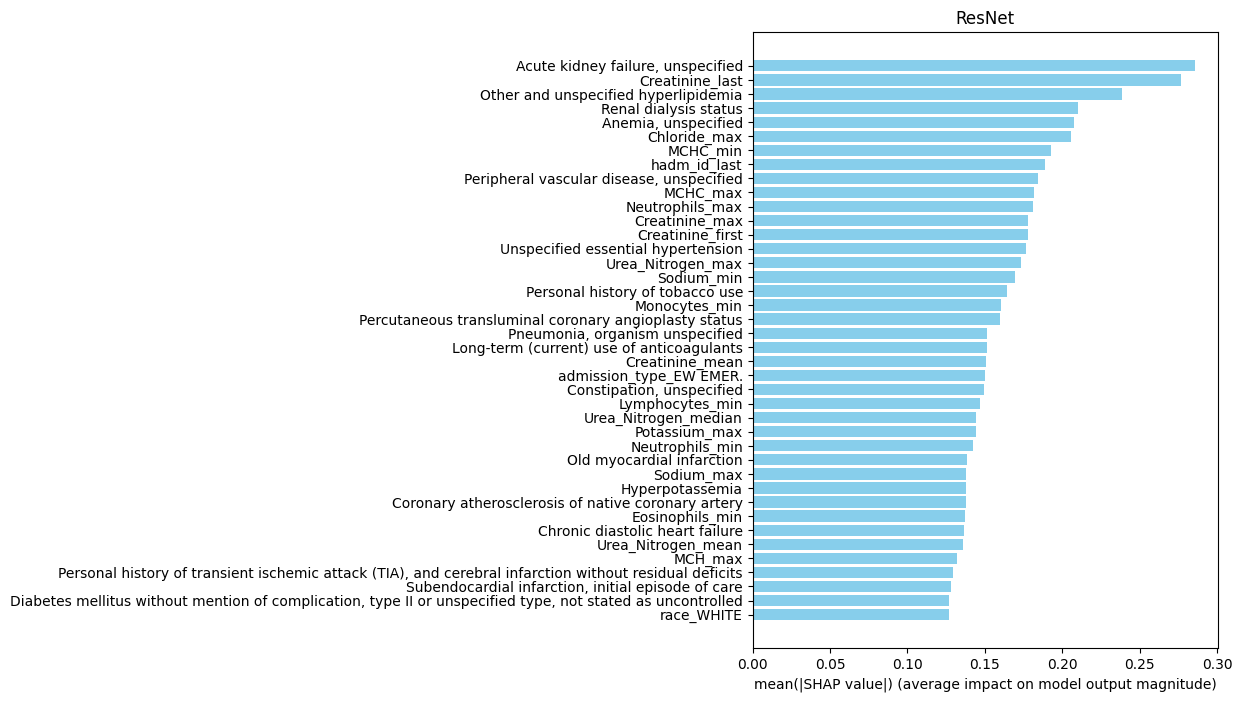

In [11]:
# Create a horizontal bar plot
plt.figure(figsize=(6, 8))
plt.barh(ResNet40[::-1], top_shap_values[::-1], color='skyblue')
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
plt.title('ResNet')

# Save the plot as a PNG file
plt.savefig("ResNetSHAP.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# SHAP Summary Plot

C:\Users\zdana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


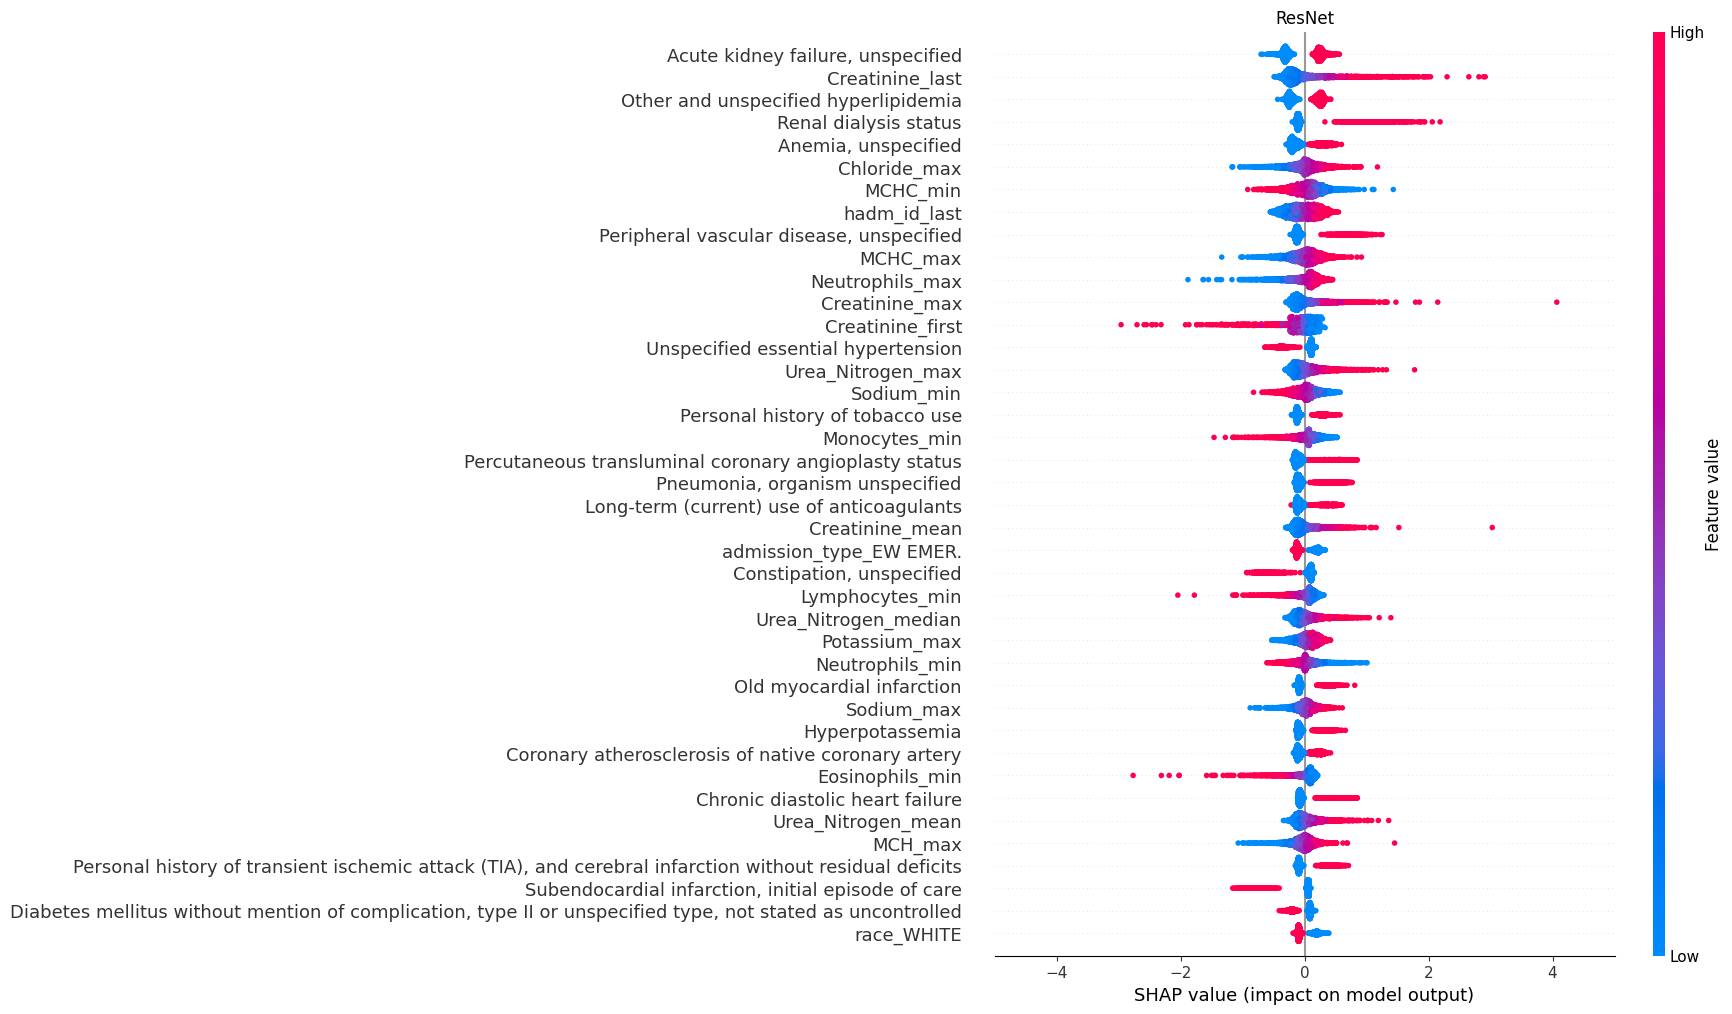

In [12]:
# Ensure X_test is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=SHAP_feature_names)

# Create a mask to select only the top 40 features from filtered_shap_values
top_40_mask = [name in ResNet40 for name in filtered_feature_names]

# Filter the SHAP values to keep only the top 40 features
top_40_shap_values = filtered_shap_values[:, top_40_mask]

# Order features by mean absolute SHAP value in descending order
mean_abs_shap_values = np.mean(np.abs(top_40_shap_values), axis=0)
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Reorder SHAP values and feature names
top_40_shap_values_sorted = top_40_shap_values[:, sorted_indices]
top_40_feature_names_sorted = np.array(filtered_feature_names)[top_40_mask][sorted_indices]

# Filter the X_test DataFrame to only include the top 40 features
X_test_top_40 = X_test[top_40_feature_names_sorted]

plt.figure(figsize=(10, 12))

# Create the summary plot with the top 40 features
shap.summary_plot(
    top_40_shap_values_sorted, 
    X_test_top_40,
    feature_names=top_40_feature_names_sorted, 
    plot_size=(10, 12), 
    max_display=40,  # Limit to top 40 features
    show=False
)

# Access the current figure and axis
fig = plt.gcf()
ax = plt.gca()

# Set x-axis limits to display SHAP values between -7.5 and 7.5
ax.set_xlim(-5, 5)

# Customize plot appearance
plt.title('ResNet')
plt.xlabel('SHAP value (impact on model output)')

# Save the plot as a PNG file
plt.savefig("ResNetBeeswarm.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Write Top 40 Features List to Pickle File

In [13]:
# Save the list to a pickle file
with open('ResNet40.pkl', 'wb') as f:
    pickle.dump(list(ResNet40), f)